# Agents & Tools - Exercises

Feel free to pick only one or several of these exercises - depending on whether you have your own data to work with and which aspects interest you.

## Set up a RAG system with your own data

If you have your own data, you can set up a RAG system yourself. You can use the workflows provided in the script. Feel free to use a different embedding model than Nomic!

In [ ]:
# ...

### Solution

In [ ]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma


lit_directory = "./my_documents/" # directory with literature to load for the RAG -  !! SET YOUR DOCUMENT DIRECTORY HERE !!
db_directory = "./data/test_chroma_db" # directory to save the vector store. adjust this accordingly

short_docs = True # shorten document from pages to chunks? (set chunk size below)

embeddings = OllamaEmbeddings(model = "nomic-embed-text")

# load documents
loader = PyPDFDirectoryLoader(lit_directory)
docs = loader.load() # metadata tracks paper and page number; each page is a single document

if short_docs:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,  # chunk size (characters)
        chunk_overlap=200,  # chunk overlap (characters)
        add_start_index=True,  # track index in original document
        )
    docs = text_splitter.split_documents(docs)

# make doc vector store. as the vector store can get quite large (and takes time to initialize in memory), we use a chroma database to store the vectors    
vector_store = Chroma(
    collection_name="test_store", # name of the collection - change to taste
    embedding_function=embeddings,
    persist_directory=db_directory,  # save data locally
    )

vector_store.add_documents(docs) # add your docs to the database specified via teh db_directory


In [ ]:
# we can test our retriever here

vector_store.similarity_search("counter publics") # search for a query in the database (adjust to your topic)

In [ ]:
# turn the vector store into a retriever - YOU CAN SET SEARCH OPTIONS HERE

docs_returned = 5 # we can set the number of documents to return in the kwargs below. kwargs are specific to the underlying database!

retriever = vector_store.as_retriever(
    search_type="similarity", # similarity score; optionally with threshold ("similarity_score_threshold" with "score_threshold" kwarg)
    search_kwargs={"k": docs_returned}, # make sure the number of documents passed (k) fits into the context window
    )

In [ ]:
# build the rest of the RAG system

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def retrieve(query: str):
    # note that the function name and the doc string of the tool are provided to the model, thus should be descriptive
    """Search and return relevant text passages from scientific literature that can be used to answer the question."""
    retrieved_docs = retriever.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# build retrieval tool as tool node (receives an AI message from query_or_respond)
tools = ToolNode([retrieve])

In [ ]:
from langchain_core.messages import SystemMessage
from dotenv import load_dotenv # to load .env file
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState 


load_dotenv()
# note that ChatOpenAI fetches your API key from your environment - you only need to load the .env file

# for now, we'll use GPT 4o-mini for both tasks
textgen_llm = ChatOpenAI(model = "gpt-4o-mini-2024-07-18",
                        temperature=0.0,
                        )

# we can use different models for different tasks, e.g. a more expensive model for reasoning (should documents be retrieved?) and a cheaper model for text generation
reasoning_llm = ChatOpenAI(model = "gpt-4o-mini-2024-07-18",
                        temperature=0.0,
                        )



system_prompt = (
  "You are a helpful assistant for finding relevant text passages in scientific literature."
   "Use the following pieces of retrieved context to answer the question."
   "If you don't know the answer, just say that you don't know, don't try to make up an answer."
)


# agent to decide whether or not to use tools
def query_or_respond(state: MessagesState):
        """Generate tool call for retrieval or respond directly."""
        llm_with_tools = reasoning_llm.bind_tools([retrieve])
        response = llm_with_tools.invoke(state["messages"])
        # MessagesState appends messages to state instead of overwriting
        return {"messages": [response]}

# Generate a response
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages (that is, our retrieved documents)
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt by first adding the retrieved documents to the system prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = f"{system_prompt}\n\n{docs_content}"
    
    # ... then adding the rest of the conversation - including the user question
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = textgen_llm.invoke(prompt)
    return {"messages": [response]}

In [ ]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph
from IPython.display import Image, display

graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Use a different retrieval technique

Apart from the similarity search we previously employed, the Chroma vector store we are using also supports Maximum Marginal Relevance (MMR) search. Do some research on MMR. What does it do differently than similarity search? 

Then, set up the same system as before, but change `search_type` argument of the retriever to `"mmr"`. You should also set the additional `search_kwargs` `"fetch_k"` and `"lambda_mult"` to configure the MMR search. 

How do results differ from the similarity search?

In [ ]:
# ...

### Solution

In [ ]:
# When turning our vectors into a retriever, we can set search the search type to MMR
# Note that we can set additional search options in the search_kwargs dictionary, like the amount of documents to consider in MMR (fetch_k) and the diversification (lambda_mult)

retriever = vector_store.as_retriever(
    search_type="mmr", # similarity score; optionally with threshold ("similarity_score_threshold" with "score_threshold" kwarg)
    search_kwargs={"k": 5
                   "fetch_k": 10,
                     "lambda_mult": 0.5, # between 0 and 1, 0 is most diverse
                   }, 
    )


# the rest is identical to the RAG system above


In [ ]:
# build the rest of the RAG system

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def retrieve(query: str):
    # note that the function name and the doc string of the tool are provided to the model, thus should be descriptive
    """Search and return relevant text passages from scientific literature that can be used to answer the question."""
    retrieved_docs = retriever.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# build retrieval tool as tool node (receives an AI message from query_or_respond)
tools = ToolNode([retrieve])



In [ ]:
from langchain_core.messages import SystemMessage
from dotenv import load_dotenv # to load .env file
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState 


load_dotenv()
# note that ChatOpenAI fetches your API key from your environment - you only need to load the .env file

# for now, we'll use GPT 4o-mini for both tasks
textgen_llm = ChatOpenAI(model = "gpt-4o-mini-2024-07-18",
                        temperature=0.0,
                        )

# we can use different models for different tasks, e.g. a more expensive model for reasoning (should documents be retrieved?) and a cheaper model for text generation
reasoning_llm = ChatOpenAI(model = "gpt-4o-mini-2024-07-18",
                        temperature=0.0,
                        )



system_prompt = (
  "You are a helpful assistant for finding relevant text passages in scientific literature."
   "Use the following pieces of retrieved context to answer the question."
   "If you don't know the answer, just say that you don't know, don't try to make up an answer."
)


# agent to decide whether or not to use tools
def query_or_respond(state: MessagesState):
        """Generate tool call for retrieval or respond directly."""
        llm_with_tools = reasoning_llm.bind_tools([retrieve])
        response = llm_with_tools.invoke(state["messages"])
        # MessagesState appends messages to state instead of overwriting
        return {"messages": [response]}

# Generate a response
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages (that is, our retrieved documents)
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt by first adding the retrieved documents to the system prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = f"{system_prompt}\n\n{docs_content}"
    
    # ... then adding the rest of the conversation - including the user question
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = textgen_llm.invoke(prompt)
    return {"messages": [response]}

In [ ]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph
from IPython.display import Image, display

graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Use different LLMs in your RAG system

Use Ollama to use different models than GPT 4o-mini. Can you find a model that is good at deciding whether or not to use the retriever tool, and one that is good at generating text from the documents?

In [ ]:
# ...

### Solution

In [ ]:
# the only thing that is different, is that we drop in another LLM for textgen and reasoning, respectively.
# Make sure that the reasoning model can use tools!
# feel free to use different models for different tasks, and other models than llama3.2

from langchain_ollama import ChatOllama


# for now, we'll use GPT 4o-mini for both tasks
textgen_llm = ChatOllama(model = "llama3.2",
                        temperature=0.0,
                        num_ctx = 20000, # this sets the size of the context window!
                        # you can add additional parameters here
                        )

# we can use different models for different tasks, e.g. a more expensive model for reasoning (should documents be retrieved?) and a cheaper model for text generation
reasoning_llm = ChatOllama(model = "llama3.2",
                        temperature=0.0,
                        num_ctx = 20000, # this sets the size of the context window!
                        # you can add additional parameters here
                        )

In [ ]:
# the rest is as before, but we do not set the textgen_llm and reasoning_llm later, as we already did this here

# load vector store
vector_store = Chroma(
    collection_name="test_store", # name of the collection - change to taste
    embedding_function=embeddings,
    persist_directory=db_directory,  # save data locally
    )

# turn it into a retriever

docs_returned = 5 # we can set the number of documents to return in the kwargs below. kwargs are specific to the underlying database!

retriever = vector_store.as_retriever(
    search_type="similarity", # similarity score; optionally with threshold ("similarity_score_threshold" with "score_threshold" kwarg)
    search_kwargs={"k": docs_returned}, # make sure the number of documents passed (k) fits into the context window
    )

In [ ]:
# build the rest of the tool

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def retrieve(query: str):
    # note that the function name and the doc string of the tool are provided to the model, thus should be descriptive
    """Search and return relevant text passages from scientific literature that can be used to answer the question."""
    retrieved_docs = retriever.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# build retrieval tool as tool node (receives an AI message from query_or_respond)
tools = ToolNode([retrieve])

In [ ]:
# set up the RAG system with the models set above

from langchain_core.messages import SystemMessage
from langgraph.graph import MessagesState 


system_prompt = (
  "You are a helpful assistant for finding relevant text passages in scientific literature."
   "Use the following pieces of retrieved context to answer the question."
   "If you don't know the answer, just say that you don't know, don't try to make up an answer."
)


# agent to decide whether or not to use tools
def query_or_respond(state: MessagesState):
        """Generate tool call for retrieval or respond directly."""
        llm_with_tools = reasoning_llm.bind_tools([retrieve])
        response = llm_with_tools.invoke(state["messages"])
        # MessagesState appends messages to state instead of overwriting
        return {"messages": [response]}

# Generate a response
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages (that is, our retrieved documents)
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt by first adding the retrieved documents to the system prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = f"{system_prompt}\n\n{docs_content}"
    
    # ... then adding the rest of the conversation - including the user question
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = textgen_llm.invoke(prompt)
    return {"messages": [response]}

In [ ]:
# build the graph

from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph
from IPython.display import Image, display

graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Set up a Wikipedia Retriever

As mentioned, a retriever does not have to connect to a local vector store database. It can also connect to an API such as the Wikipedia API, which allows us to retrieve Wikipedia articles. 

Luckily, the LangChain community already set up a retriever function for the API endpoint. Use it to build a RAG system that utilizes wikipedia articles!

_Hint_: The documents returned by the wikipedia retriever contain a "summary" field. Maybe this will be enough to pass to your model - rather than a full article?

In [1]:
from langchain_community.retrievers import WikipediaRetriever
 
article_retriever = WikipediaRetriever(doc_content_chars_max=1000, # setting this very high means we will retrieve the full article. Watch the context window size of your model if passing them full!
                                       top_k_results=10) # this sets the number of articles to retrieve


#...

### Solution

In [22]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
 
article_retriever = WikipediaRetriever(doc_content_chars_max=1000, # setting this very high means we will retrieve the full article. Watch the context window size of your model if passing them full!
                                       top_k_results=10) # this sets the number of articles to retrieve

@tool
def wikipedia(query: str):
    """Search Wikipedia and return article summaries to help answer the question."""

    retrieved_docs = article_retriever.invoke(query)
    serialized = "\n\n".join(
        (f"Title: {doc.metadata["title"]}\n" f"Summary: {doc.metadata["summary"]}\n" f"Source: {doc.metadata["source"]}\n")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

tools = ToolNode([wikipedia])

In [23]:
# we can copy and paste the code from the previous RAG system, we only need to change the system prompt, and the bind_tools function

from langchain_core.messages import SystemMessage
from dotenv import load_dotenv # to load .env file
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState 


load_dotenv()
# note that ChatOpenAI fetches your API key from your environment - you only need to load the .env file

# for now, we'll use GPT 4o-mini for both tasks
textgen_llm = ChatOpenAI(model = "gpt-4o-mini-2024-07-18",
                        temperature=0.0,
                        )

# we can use different models for different tasks, e.g. a more expensive model for reasoning (should documents be retrieved?) and a cheaper model for text generation
reasoning_llm = ChatOpenAI(model = "gpt-4o-mini-2024-07-18",
                        temperature=0.0,
                        )



system_prompt = (
  "You are a helpful assistant for answering general knowledge questions."
   "Use the following pieces of retrieved context to answer the question."
   "If you don't know the answer, just say that you don't know, don't try to make up an answer."
)


# agent to decide whether or not to use tools
def query_or_respond(state: MessagesState):
        """Generate tool call for retrieval or respond directly."""
        llm_with_tools = reasoning_llm.bind_tools([wikipedia])
        response = llm_with_tools.invoke(state["messages"])
        # MessagesState appends messages to state instead of overwriting
        return {"messages": [response]}

# Generate a response
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages (that is, our retrieved documents)
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt by first adding the retrieved documents to the system prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = f"{system_prompt}\n\n{docs_content}"
    
    # ... then adding the rest of the conversation - including the user question
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = textgen_llm.invoke(prompt)
    return {"messages": [response]}

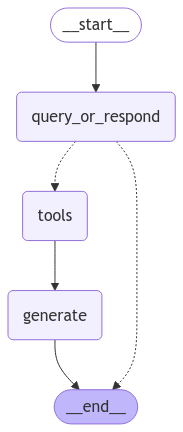

In [24]:
# we bult our graph, same as before

from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph
from IPython.display import Image, display

graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [25]:
input_message = "Who is Jürgen Habermas?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Who is Jürgen Habermas?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_uSJMwe45iA5yxrZyeLJkPRIB)
 Call ID: call_uSJMwe45iA5yxrZyeLJkPRIB
  Args:
    query: Jürgen Habermas
================================= Tool Message =================================
Name: wikipedia

('Title: Jürgen Habermas\nSummary: Jürgen Habermas (UK:   HAH-bər-mass, US:  -\u2060mahss; German: [ˈjʏʁɡn̩ ˈhaːbɐmaːs] ; born 18 June 1929) is a German philosopher and social theorist in the tradition of critical theory and pragmatism. His work addresses communicative rationality and the public sphere.\nAssociated with the Frankfurt School, Habermas\'s work focuses on the foundations of epistemology and social theory, the analysis of advanced capitalism and democracy, the rule of law in a critical social-evolutionary context, albeit within the confines of the natural law tradi

## Other use cases for agentic systems

Come up with some use cases for agentic systems with or without tools. Could you use them in your research? What would the components be? Try your hand at building such a system!

In [ ]:
# ...